# Refined Modeling Using 35 Species Classifications

In [1]:
# Imports & Setup:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import PIL
import PIL.Image
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

%matplotlib inline

import warnings

warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42)

### Read in Data

In [2]:
# function to load in and process images
def load_image(path):
    images = Image.open(f'./../CUB_200_2011/images/{path}') 
    new_image=images.resize((128,128))
    color_image=new_image.convert("RGB")
    arrays1 = np.asarray(color_image)
    floaters= arrays1.astype('float32')
    floaters2=floaters/255.0
    return floaters2

In [3]:
class_map_dir= pd.read_csv('Tables/class_map_dir_output_new_classes_f.csv')
class_map_dir.head(5)

,F1,Image Id,Image Name,Is Training Image,Class Id,Class Name,Species Gen,Order,Order_Num_Seq,Species,Species_Num_Seq,Family,Family_Num_Seq
0,0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,0,1,001.Black_footed_Albatross,Albatrosses,PROCELLARIIFORMES,11,Albatrosses,1,Diomedeidae,11
1,1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,001.Black_footed_Albatross,Albatrosses,PROCELLARIIFORMES,11,Albatrosses,1,Diomedeidae,11
2,2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,0,1,001.Black_footed_Albatross,Albatrosses,PROCELLARIIFORMES,11,Albatrosses,1,Diomedeidae,11
3,3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,001.Black_footed_Albatross,Albatrosses,PROCELLARIIFORMES,11,Albatrosses,1,Diomedeidae,11
4,4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,001.Black_footed_Albatross,Albatrosses,PROCELLARIIFORMES,11,Albatrosses,1,Diomedeidae,11


In [4]:
species_names=[
"Albatrosses",
"Auks",
"Cardinals, Allies",
"Cormorants and Shags",
"Crows, Jays, Magpies",
"Cuckoos",
"Ducks, Geese, Waterfowl",
"Finches, Euphonias, Allies",
"Frigates",
"Grebes",
"Gulls, Terns, Skimmers",
"Hummingbirds",
"Kingfishers",
"Larks",
"Loons",
"Mickingbirds and Thrashers",
"New World Sparrows",
"New World Warblers",
"Nightjars and Allies",
"Nuthatches",
"Pelicans",
"Shearwaters and Petrels",
"Shrikes",
"Skuas and Jaegers",
"Starlings",
"Swallows",
"Treecreepers",
"Troupials and Allies",
"Tyrant Flycatchers",
"Vireos, Shrike-Babblers, Erpornis",
"Wagtails and Pipits",
"Waxwings",
"Woodpeckers",
"Wrens",
"Yellow-breasted Chat"
]

In [5]:
order_names_sorted=list(enumerate(species_names, start=1))
list(order_names_sorted)

[(1, 'Albatrosses'),
 (2, 'Auks'),
 (3, 'Cardinals, Allies'),
 (4, 'Cormorants and Shags'),
 (5, 'Crows, Jays, Magpies'),
 (6, 'Cuckoos'),
 (7, 'Ducks, Geese, Waterfowl'),
 (8, 'Finches, Euphonias, Allies'),
 (9, 'Frigates'),
 (10, 'Grebes'),
 (11, 'Gulls, Terns, Skimmers'),
 (12, 'Hummingbirds'),
 (13, 'Kingfishers'),
 (14, 'Larks'),
 (15, 'Loons'),
 (16, 'Mickingbirds and Thrashers'),
 (17, 'New World Sparrows'),
 (18, 'New World Warblers'),
 (19, 'Nightjars and Allies'),
 (20, 'Nuthatches'),
 (21, 'Pelicans'),
 (22, 'Shearwaters and Petrels'),
 (23, 'Shrikes'),
 (24, 'Skuas and Jaegers'),
 (25, 'Starlings'),
 (26, 'Swallows'),
 (27, 'Treecreepers'),
 (28, 'Troupials and Allies'),
 (29, 'Tyrant Flycatchers'),
 (30, 'Vireos, Shrike-Babblers, Erpornis'),
 (31, 'Wagtails and Pipits'),
 (32, 'Waxwings'),
 (33, 'Woodpeckers'),
 (34, 'Wrens'),
 (35, 'Yellow-breasted Chat')]

## Prep Dataset & Train/Test Split


In [6]:
class_map_dir_train=class_map_dir.loc[class_map_dir['Is Training Image']==1]
list_of_images_train=[load_image(i) for i in class_map_dir_train['Image Name']]
array_of_img_train=np.asarray(list_of_images_train)
list_of_labels_train=class_map_dir_train['Species_Num_Seq']

In [7]:
class_map_dir_test=class_map_dir.loc[class_map_dir['Is Training Image']==0]
list_of_images_test=[load_image(i) for i in class_map_dir_test['Image Name']]
array_of_img_test=np.asarray(list_of_images_test)
list_of_labels_test=class_map_dir_test['Species_Num_Seq']

In [8]:
# sanity check length of train datasets
print(len(list_of_images_train))
print(len(list_of_labels_train))

# sanity check length of test datasets
print(len(list_of_images_test))
print(len(list_of_labels_test))

5994
5994
5794
5794


In [9]:
X_train_alt=array_of_img_train
y_train_alt=list_of_labels_train

X_test_alt=array_of_img_test
y_test_alt=list_of_labels_test

X_train_alt = X_train_alt.reshape(X_train_alt.shape[0], 128, 128, 3)
X_test_alt = X_test_alt.reshape(X_test_alt.shape[0], 128, 128, 3)
y_train_alt = utils.to_categorical(y_train_alt,36)
y_test_alt = utils.to_categorical(y_test_alt,36)


## Transfer Learning 

In [10]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (128, 128)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
#base_model.summary()

## Build Neural Networks

In [14]:
model_spt44 = Sequential([ base_model,
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

model_spt44.add(Flatten(input_shape = (128, 128, 3)))
model_spt44.add(Dense(256, activation = 'relu'))
model_spt44.add(Dense(128, activation = 'relu'))
model_spt44.add(Dense(128, activation = 'relu'))
model_spt44.add(Dense(64, activation = 'relu'))
model_spt44.add(Dense(48, activation = 'relu'))

model_spt44.add(Dense(36, activation = 'softmax'))
# Compile model.
model_spt44.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_spt44.trainable = True
#early_stop = EarlyStopping(monitor = 'val_accuracy', min_delta=0, patience = 5, verbose = 1, mode = 'auto')
history_spt44  = model_spt44.fit(X_train_alt,
                    y_train_alt, 
                    batch_size=256,
                    validation_data=(X_test_alt, y_test_alt),
                    epochs=30,
                    verbose=1)
    #                ,callbacks = [early_stop])

Epoch 1/50
21/24 [=========================>....] - ETA: 23s - loss: 2.6968 - accuracy: 0.2987

KeyboardInterrupt: 

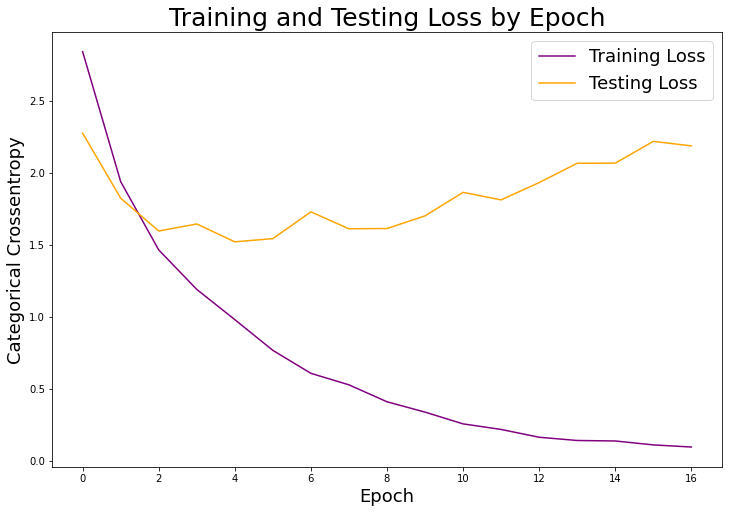

In [12]:
# Check out our train loss and test loss over epochs.
train_loss = history_spt4.history['loss']
test_loss = history_spt4.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='purple')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)

plt.legend(fontsize = 18);

In [13]:
history_spt4.history['accuracy'][-1], history_spt4.history['val_accuracy'][-1]

(0.9716383218765259, 0.6061443090438843)

In [15]:
model_spt4.save('saved_models/species_est4.h5')

In [16]:
model_spt.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 random_flip_1 (RandomFlip)  (None, 4, 4, 1280)        0         
                                                                 
 random_rotation_1 (RandomRo  (None, 4, 4, 1280)       0         
 tation)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 20480)             0         
                                                                 
 dense_8 (Dense)             (None, 512)               10486272  
                                                                 
 dropout_4 (Dropout)         (None, 512)              

## Working with the saved model 

In [17]:
new_model_uploaded = tf.keras.models.load_model('saved_models/species_est.h5')

In [18]:
# Prep data for confusion matrix
predictions=new_model_uploaded.predict(X_test_alt) 
pred_f=np.argmax(predictions,axis=1)
y_test_f=np.argmax(y_test_alt,axis=1)

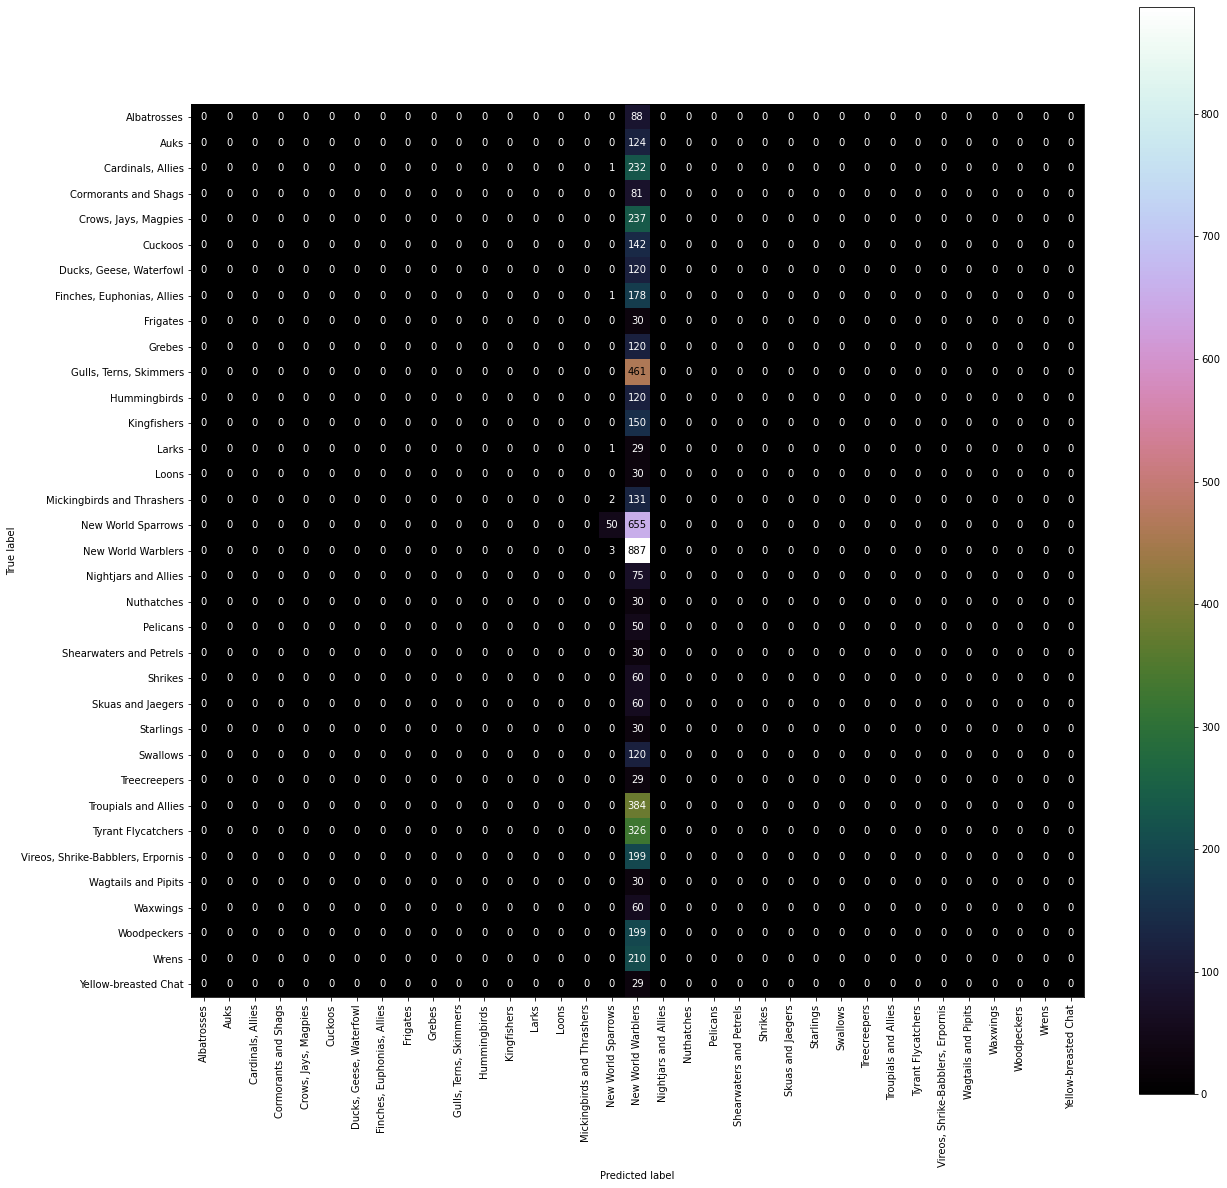

In [20]:
cm = metrics.confusion_matrix(y_test_f, pred_f) #set normalize = true to see the % distribution by row 
fig, ax = plt.subplots(figsize=(20, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_names)
disp.plot(ax=ax, cmap='cubehelix')
plt.xticks(rotation=90);

In [ ]:
# LOAD AN EXAMPLE IMAGE

In [21]:
def load_image(path):
    images = Image.open(f'./../CUB_200_2011/images/{path}') 
    new_image=images.resize((128,128))
    color_image=new_image.convert("RGB")
    arrays1 = np.asarray(color_image)
    floaters= arrays1.astype('float32')
    floaters2=floaters/255.0
    return floaters2

In [22]:
example1=load_image("017.Cardinal/Cardinal_0022_17233.jpg")
example2=np.asarray(example1)
example3 = example2.reshape(1, 128, 128, 3)

In [23]:
predictions1=new_model_uploaded.predict(example3) 
pred_f1=np.argmax(predictions1,axis=1)


In [24]:
predictions1


array([[0.00119612, 0.01325024, 0.0203125 , 0.09520333, 0.01034131,
        0.01080076, 0.00204941, 0.00107638, 0.01670952, 0.02884946,
        0.04691171, 0.06700974, 0.01049269, 0.00763841, 0.0009834 ,
        0.00415118, 0.02048967, 0.04741524, 0.4118873 , 0.00580888,
        0.02269954, 0.01165126, 0.00339011, 0.00120996, 0.00056073,
        0.00098858, 0.00372379, 0.00498134, 0.03273429, 0.03368142,
        0.02852329, 0.00527627, 0.00194176, 0.00795088, 0.01733801,
        0.00077149]], dtype=float32)

In [25]:
max_pred=np.max(predictions1)
max_pred_perc=max_pred*100
format_pred_perc = "{:.2f}".format(max_pred_perc)
print (f'The model is {format_float}% sure that this species belongs to THAT!')

NameError: name 'format_float' is not defined

In [26]:
max_pred=np.max(predictions1)
result=np.where(predictions1==max_pred)
classification_index=result[1]
classification_index
#print("Elements with max value exists at following indices", result[1])

array([18], dtype=int64)

In [27]:
print(pred_f1)
print(int(pred_f1))

[18]
18


In [29]:
species_names[int(pred_f1)-1]

'New World Warblers'

In [70]:
#Function to upload an image 
def load_image_new(path):
    images = Image.open(f'{path}') 
    new_image=images.resize((128,128))
    color_image=new_image.convert("RGB")
    arrays1 = np.asarray(color_image)
    floaters= arrays1.astype('float32')
    floaters2=floaters/255.0
    floaters3=np.asarray(floaters2)
    floaters4 = floaters3.reshape(1, 128, 128, 3)
    return floaters4

In [83]:
test_case1=load_image_new("test_images/cardinal_1.jpg")

predictions3=new_model_uploaded.predict(test_case1) 
pred_f3=np.argmax(predictions3,axis=1)
class_names[int(pred_f3)-1]

'PASSERIFORMES'

In [87]:
predictions3

array([[1.0901128e-21, 4.8088803e-12, 3.1519714e-09, 4.9259569e-07,
        6.3373384e-13, 2.6862508e-09, 5.4394066e-11, 9.9999952e-01,
        9.4033548e-13, 1.2013467e-10, 3.3951086e-14, 2.3698181e-12,
        1.7745485e-13]], dtype=float32)

In [89]:
## Streamlit Test Code

In [85]:
#Function to upload an image 
def load_image_new(path):
    images = Image.open(path) 
    new_image=images.resize((128,128))
    color_image=new_image.convert("RGB")
    arrays1 = np.asarray(color_image)
    floaters= arrays1.astype('float32')
    floaters2=floaters/255.0
    floaters3=np.asarray(floaters2)
    floaters4 = floaters3.reshape(1, 128, 128, 3)
    return floaters4

In [86]:
test_case1=load_image_new("test_images/albatross.jpg")

In [87]:
#function to classify birds in Streamlit

def predict_birds_order_with_prob(file):
    best_model_1 = tf.keras.models.load_model('saved_models/order_es.h5')
    preds1=best_model_1.predict(file)
    preds2=np.argmax(preds1,axis=1)
    max_pred=np.max(preds1)
    max_pred_perc=max_pred*100
    format_pred_perc = "{:.2f}".format(max_pred_perc)
    return format_pred_perc, order_names[int(preds2)-1]


In [30]:
model_spt2 = Sequential([ base_model,
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

model_spt2.add(Flatten(input_shape = (128, 128, 3)))
model_spt2.add(Dense(128, activation = 'relu'))
model_spt2.add(Dense(128, activation = 'relu'))
model_spt2.add(Dense(64, activation = 'relu'))
model_spt2.add(Dense(48, activation = 'relu'))

model_spt2.add(Dense(36, activation = 'softmax'))
# Compile model.
model_spt2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_spt2.trainable = True
early_stop = EarlyStopping(monitor = 'val_accuracy', min_delta=0, patience = 5, verbose = 1, mode = 'auto')
history_spt2  = model_spt2.fit(X_train_alt,
                    y_train_alt, 
                    batch_size=256,
                    validation_data=(X_test_alt, y_test_alt),
                    epochs=10,
                    verbose=1,
                    callbacks = [early_stop])

Epoch 1/10
24/24 [==============================] - 265s 11s/step - loss: 2.7896 - accuracy: 0.3151 - val_loss: 6.1448 - val_accuracy: 0.1160
Epoch 2/10
24/24 [==============================] - 268s 11s/step - loss: 1.8698 - accuracy: 0.4900 - val_loss: 6.7854 - val_accuracy: 0.1332
Epoch 3/10
24/24 [==============================] - 240s 10s/step - loss: 1.2606 - accuracy: 0.6375 - val_loss: 8.1474 - val_accuracy: 0.2100
Epoch 4/10
24/24 [==============================] - 260s 11s/step - loss: 0.8433 - accuracy: 0.7509 - val_loss: 10.7366 - val_accuracy: 0.1289
Epoch 5/10
24/24 [==============================] - 262s 11s/step - loss: 0.6355 - accuracy: 0.8023 - val_loss: 11.8096 - val_accuracy: 0.0873
Epoch 6/10
24/24 [==============================] - 270s 11s/step - loss: 0.4885 - accuracy: 0.8567 - val_loss: 18.1032 - val_accuracy: 0.0920
Epoch 7/10
24/24 [==============================] - 271s 11s/step - loss: 0.3871 - accuracy: 0.8867 - val_loss: 21.9341 - val_accuracy: 0.0618
Ep